Vanessa Türker, Data Science MyDailyImpact, 24.02.25

# MyDailyImpact - Analysis and prediction of user behaviour in relation to activity



*With the MayDailyImpact app, users worldwide can recognise the impact of their plant-based diet in terms of saving CO2, water, land and animal life. In addition to specifying which plant-based meal they have eaten (breakfast, lunch or dinner), they can enter the recipe name and add notes.*

__As every individual impact counts towards strengthening the environment, recognising whether a user will use the app in the future or leave it is hugely important. With machine learning predictions based on user behaviour and other parameters, predictive measures could be taken to further motivate the users and prevent them from leaving.__ 

A marketing team could, for example, use these predictions to send motivational emails or push messages to users.

__As the app is not yet online, we created our own data set for the analysis with the kind support of the mentor Zubin John:__ synthetic_activity_dataset-v0.csv

In the future, real data can then be incorporated into the analysis, thereby improving results.

## Recipe Dataset Creation:

The following steps were taken:

* We define 50 unique dish names and a mapping of ingredients to possible plant-based substitutes.
* For each dish, we generate a non-empty list of 3–6 ingredients.
* For each ingredient, we assign a random portion size (in grams) and a random carbon footprint value (kg CO₂e).
* The substitutions list is aligned with the ingredients list (using a substitute when available, or None).
* This will need to be fixed in the future. Ingredient lists are not realistic.

## Activity Log Generation:

The following steps were taken:

* Six personas are defined with specific parameters (e.g., record count, weight/height ranges, home country, dish preferences, meal type distribution, and substitution probability).
* For each record, a unique record_id, user profile fields, and a timestamp (within a meal-type-specific time window over the past 2 years) are generated.
* A recipe is sampled from the recipe dataset (filtered by dish preferences when possible), and its fields are assigned to the record.
* Additional fields like substitutions_made, hunger_rating, meal_rating, and geo_location are also generated.

This process creates a complete activity log record with all 16 fields.

## Churn Prediction:

_The next step is to carry out a ‘churn prediction’._

__As all users are active and there is no database, a different approach is taken. This focuses on user inactivity, which in the worst case could lead to users leaving the platform.__
With the prediction of users at risk, a marketing department could take countermeasures and activate the user through email marketing or push messages, shortly after a predefined non-interactive phase has been completed.

### Data Analysis


The first step is to read in the dataset, look at it in detail and create a copy (as a precautionary measure). Because the data is synthetic, we already know a lot about the individual personas. These are therefore not analysed further.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read CSV
df = pd.read_csv('data/synthetic_activity_dataset-v0.csv')

# show head
print(df.head())


   record_id       user_id   activity_timestamp  weight  height  \
0  rec_00369     Fit Felix  2023-02-18 09:32:24    71.5   176.3   
1  rec_01291     Diet Dani  2023-02-18 12:11:06    80.8   170.2   
2  rec_00437     Fit Felix  2023-02-18 12:42:09    74.4   179.5   
3  rec_01236     Diet Dani  2023-02-18 18:10:54    80.2   169.0   
4  rec_01627  Travel Terry  2023-02-19 20:52:12    79.8   181.6   

  country_of_residence         dish_name  meal_type  \
0          Netherlands      Quinoa Salad  Breakfast   
1                Italy  Zucchini Noodles      Lunch   
2          Netherlands      Quinoa Salad      Lunch   
3                Italy     Smoothie Bowl     Dinner   
4                Japan       Vegan Chili     Dinner   

                                     ingredient_list  \
0            ['onion', 'beef', 'yogurt', 'mushroom']   
1                 ['salt', 'pork', 'yogurt', 'fish']   
2            ['onion', 'beef', 'yogurt', 'mushroom']   
3                      ['salt', 'spinach',

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   record_id                  1900 non-null   object 
 1   user_id                    1900 non-null   object 
 2   activity_timestamp         1900 non-null   object 
 3   weight                     1900 non-null   float64
 4   height                     1900 non-null   float64
 5   country_of_residence       1900 non-null   object 
 6   dish_name                  1900 non-null   object 
 7   meal_type                  1900 non-null   object 
 8   ingredient_list            1900 non-null   object 
 9   substitutions_list         1900 non-null   object 
 10  substitutions_made         1900 non-null   int64  
 11  carbon_footprint_original  1900 non-null   object 
 12  portion_size               1900 non-null   object 
 13  hunger_rating              1900 non-null   int64

We get a compact overview of the DataFrame, including the number of rows, the number of columns, the data types and the non-null values in each column.

In [27]:
df.nunique()

record_id                    1900
user_id                         6
activity_timestamp           1899
weight                        221
height                        191
country_of_residence            6
dish_name                      48
meal_type                       3
ingredient_list                49
substitutions_list             46
substitutions_made              2
carbon_footprint_original      49
portion_size                   49
hunger_rating                   5
meal_rating                     4
geo_location                 1899
dtype: int64

This method makes it easier to decide which columns should be used for model training, especially when working with categorical data.

In [28]:
df.describe()

,weight,height,substitutions_made,hunger_rating,meal_rating
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,72.676789,172.247053,0.372632,3.450000,3.876316
std,8.889483,5.636173,0.483632,0.740838,0.672930
min,55.000000,163.000000,0.000000,1.000000,2.000000
25%,61.700000,167.600000,0.000000,3.000000,3.000000
50%,76.300000,170.800000,0.000000,3.000000,4.000000
75%,79.400000,178.200000,1.000000,4.000000,4.000000
max,85.000000,182.000000,1.000000,5.000000,5.000000


Another quick overview is provided by this method, whereby we already know a large part from the outset due to the data we have built up ourselves.

#### Copy of Dataset

In [3]:
# Create a copy of the data file as a backup

df_copy = df.copy()

#### Display options

In [30]:
from IPython.display import display

# Jupyter Notebook display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)

# Show DataFrame
display(df)


,record_id,user_id,activity_timestamp,weight,height,country_of_residence,dish_name,meal_type,ingredient_list,substitutions_list,substitutions_made,carbon_footprint_original,portion_size,hunger_rating,meal_rating,geo_location
0,rec_00369,Fit Felix,2023-02-18 09:32:24,71.5,176.3,Netherlands,Quinoa Salad,Breakfast,"['onion', 'beef', 'yogurt', 'mushroom']","[None, 'seitan', 'coconut yogurt', None]",0,"[0.42, 4.57, 2.88, 3.62]","[256, 130, 152, 118]",4,4,"(52.3622, 4.9089)"
1,rec_01291,Diet Dani,2023-02-18 12:11:06,80.8,170.2,Italy,Zucchini Noodles,Lunch,"['salt', 'pork', 'yogurt', 'fish']","[None, 'jackfruit', 'coconut yogurt', 'tempeh']",0,"[4.19, 0.9, 1.84, 3.38]","[147, 121, 166, 212]",3,3,"(41.9106, 12.4873)"
2,rec_00437,Fit Felix,2023-02-18 12:42:09,74.4,179.5,Netherlands,Quinoa Salad,Lunch,"['onion', 'beef', 'yogurt', 'mushroom']","[None, 'seitan', 'coconut yogurt', None]",1,"[0.42, 4.57, 2.88, 3.62]","[256, 130, 152, 118]",3,5,"(52.3655, 4.8923)"
3,rec_01236,Diet Dani,2023-02-18 18:10:54,80.2,169.0,Italy,Smoothie Bowl,Dinner,"['salt', 'spinach', 'cheese']","[None, None, 'vegan cheese']",1,"[0.89, 4.77, 4.62]","[89, 145, 245]",3,3,"(41.8916, 12.513)"
4,rec_01627,Travel Terry,2023-02-19 20:52:12,79.8,181.6,Japan,Vegan Chili,Dinner,"['broccoli', 'rice', 'tofu', 'chicken', 'fish', 'beef']","[None, None, None, 'tofu', 'tempeh', 'seitan']",1,"[0.28, 1.91, 2.81, 2.21, 0.3, 1.89]","[291, 276, 226, 281, 88, 189]",4,4,"(48.8488, 2.3658)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,rec_00441,Fit Felix,2025-02-15 09:08:08,74.6,179.2,Netherlands,Quinoa Salad,Breakfast,"['onion', 'beef', 'yogurt', 'mushroom']","[None, 'seitan', 'coconut yogurt', None]",1,"[0.42, 4.57, 2.88, 3.62]","[256, 130, 152, 118]",3,4,"(52.383, 4.9104)"
1896,rec_01064,Budget Billie,2025-02-15 09:38:55,61.0,163.9,India,Simple Pasta,Breakfast,"['beef', 'pasta', 'broccoli', 'fish', 'tomato']","['seitan', None, None, 'tempeh', None]",0,"[3.13, 4.32, 2.93, 3.55, 0.32]","[70, 191, 125, 262, 210]",5,3,"(12.9851, 77.6131)"
1897,rec_00113,Hardcore Henrietta,2025-02-15 13:33:24,82.1,170.2,Germany,Protein Pasta,Lunch,"['chicken', 'pepper', 'yogurt']","['tofu', None, 'coconut yogurt']",1,"[0.6, 3.73, 2.77]","[107, 85, 238]",4,5,"(52.5137, 13.3992)"
1898,rec_00089,Hardcore Henrietta,2025-02-15 13:40:50,75.4,173.7,Germany,Protein Pasta,Lunch,"['chicken', 'pepper', 'yogurt']","['tofu', None, 'coconut yogurt']",0,"[0.6, 3.73, 2.77]","[107, 85, 238]",4,5,"(52.5145, 13.417)"


## Churn Prediction

### Steps for creating a churn column:

Here we want to predict how likely a user is to leave the platform. Since we don't have ‘churn’ data as a target so far, this column is created based on the following considerations:

To measure inactivity, we calculate the time intervals between the logs. As this is random data, we consider the time span of 14 days to be relevant.

So we initially assume a period of 14 days during which the user is inactive. As this is randomly generated data (up to 450 logs in total within 2 years), we may adjust this assumption again depending on the results. This value would certainly have to be adjusted for an app used later in the real world.

In [4]:
# the last date used in the Dataset
last_activity_date = df['activity_timestamp'].max()

# the last date used in the Dataset
print("The last date used is:", last_activity_date)

The last date used is: 2025-02-16 13:55:09


In [5]:
# Convert the activity_timestamp column to datetime format
df['activity_timestamp'] = pd.to_datetime(df['activity_timestamp'])

# Sort the DataFrame by user_id and activity_timestamp
df = df.sort_values(by=['user_id', 'activity_timestamp'])

# Calculate the time interval between logs for each user
df['previous_activity'] = df.groupby('user_id')['activity_timestamp'].shift(1)
df['inactivity_duration'] = (df['activity_timestamp'] - df['previous_activity']).dt.days


In [6]:
# Check for incorrect conversions
if df['inactivity_duration'].isnull().values.any():
    df['inactivity_duration'].fillna(0, inplace=True)  # Nullwerte durch 0 ersetzen

# Find maximum and minimum inactivity value
max_inactivity = df['inactivity_duration'].max()
min_inactivity = df['inactivity_duration'].min()

# Display of the maximum and minimum inactivity value
print("Maximum inactivity (in days):", max_inactivity)
print("Minimal nactivity (in days):", min_inactivity)

Maximum inactivity (in days): 17.0
Minimal nactivity (in days): 0.0


C:\Users\Vanessa\AppData\Local\Temp\ipykernel_22260\3224093890.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['inactivity_duration'].fillna(0, inplace=True)  # Nullwerte durch 0 ersetzen


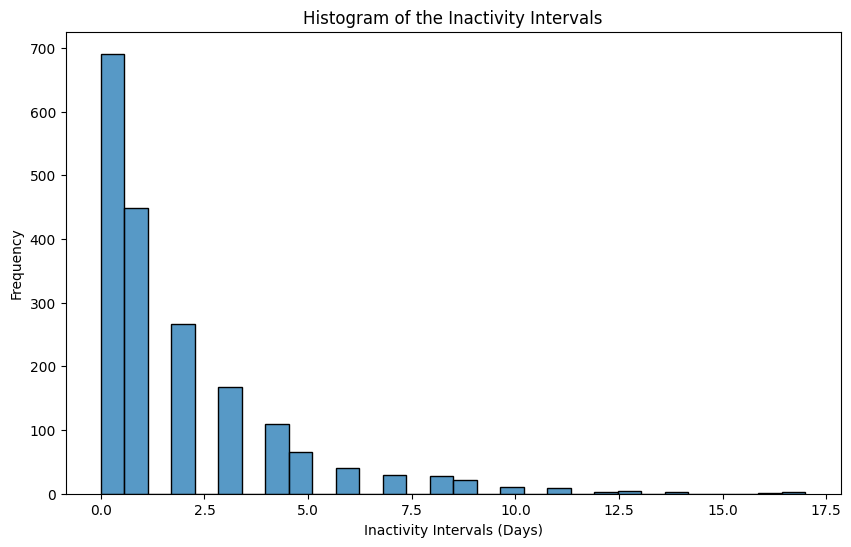

In [11]:
# Create histogram of the inactivity intervals
plt.figure(figsize=(10, 6))
sns.histplot(df['inactivity_duration'], bins=30, kde=False)
plt.xlabel('Inactivity Intervals (Days)')
plt.ylabel('Frequency')
plt.title('Histogram of the Inactivity Intervals')
plt.show()

As you can see, the data set is very imbalanced. In order to make better predictions, we therefore take a closer look at the threshold value. This should have a distribution of at least 80 to 20 per cent, or even better, in order to be meaningful.

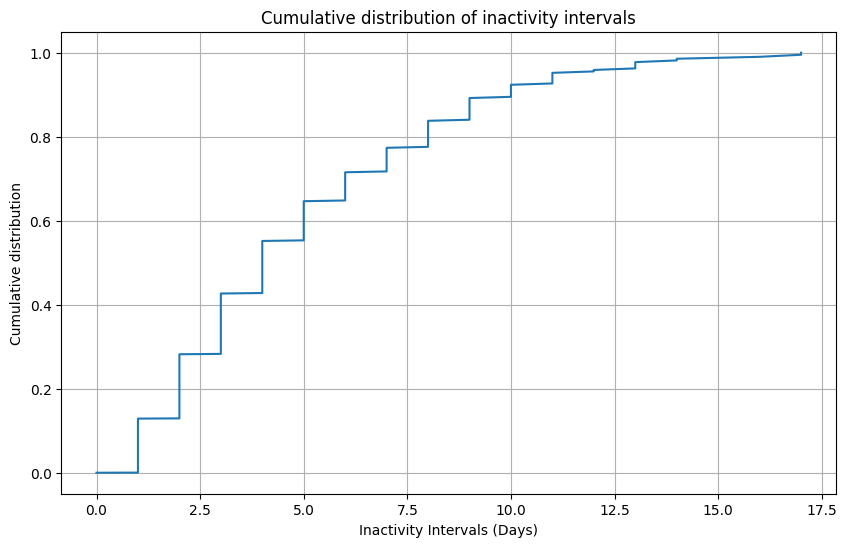

Threshold value for 80% of inactive days: 3.0 days
Threshold value for 60% of inactive days: 1.3999999999998636 days


In [14]:
# Cumulative distribution of inactivity intervals
sorted_inactivity = df['inactivity_duration'].sort_values()
cumulative = sorted_inactivity.cumsum() / sorted_inactivity.sum()

# Diagram of the cumulative distribution
plt.figure(figsize=(10, 6))
plt.plot(sorted_inactivity, cumulative)
plt.xlabel('Inactivity Intervals (Days)')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative distribution of inactivity intervals')
plt.grid(True)
plt.show()

# Determine threshold values 80/20 or 60/40
threshold_80 = sorted_inactivity.quantile(0.80)
threshold_60 = sorted_inactivity.quantile(0.60)

print(f"Threshold value for 80% of inactive days: {threshold_80} days")
print(f"Threshold value for 60% of inactive days: {threshold_60} days")

__Since these are artificial data, the threshold value of 3.0 days for 80% of users and 1.4 days for 60% is very far removed from reality, where values of 14 days and more are more likely to be expected.__

*Nevertheless, we calculate a threshold value of 3 days for our model based on the current data set. This value urgently needs to be harmonised with real data.*

In [24]:
# Definition of an inactivity threshold (in this case 2 days)
inactivity_threshold = 3
df['inactive'] = df['inactivity_duration'] > inactivity_threshold

# Show DataFrame
print(df)

      record_id        user_id  activity_timestamp  weight  height  \
13    rec_00945  Budget Billie 2023-02-21 20:12:12    58.7   164.9   
26    rec_01139  Budget Billie 2023-02-26 20:43:05    58.3   166.1   
27    rec_00934  Budget Billie 2023-02-28 14:38:58    60.9   166.0   
36    rec_01089  Budget Billie 2023-03-04 14:03:35    59.4   166.0   
39    rec_01028  Budget Billie 2023-03-05 12:55:50    59.0   165.1   
...         ...            ...                 ...     ...     ...   
1855  rec_00709     Vegan Vera 2025-02-02 19:49:23    55.3   167.7   
1865  rec_00713     Vegan Vera 2025-02-05 14:58:54    55.9   167.4   
1871  rec_00698     Vegan Vera 2025-02-07 13:59:31    57.6   165.0   
1875  rec_00864     Vegan Vera 2025-02-08 07:51:31    59.3   166.5   
1881  rec_00896     Vegan Vera 2025-02-11 12:08:58    56.3   169.8   

     country_of_residence           dish_name  meal_type  \
13                  India  Ramen with Veggies     Dinner   
26                  India  Ramen with V

### Count the number of inactive users per country & weight/height

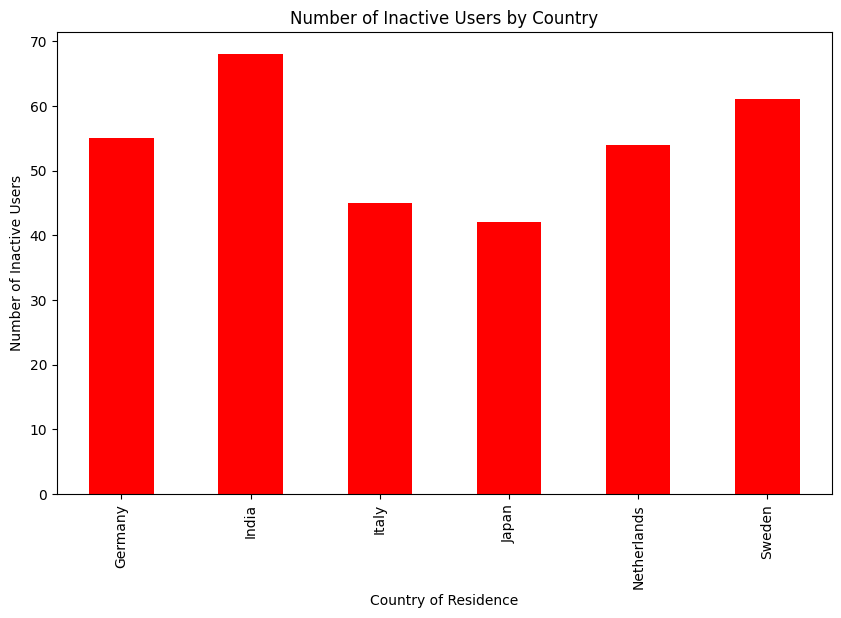

In [25]:
# Count the number of inactive users per country
inactive_counts = df[df['inactive']].groupby('country_of_residence').size()

# Create bar chart
inactive_counts.plot(kind='bar', color='red', figsize=(10, 6))
plt.xlabel('Country of Residence')
plt.ylabel('Number of Inactive Users')
plt.title('Number of Inactive Users by Country')
plt.show()

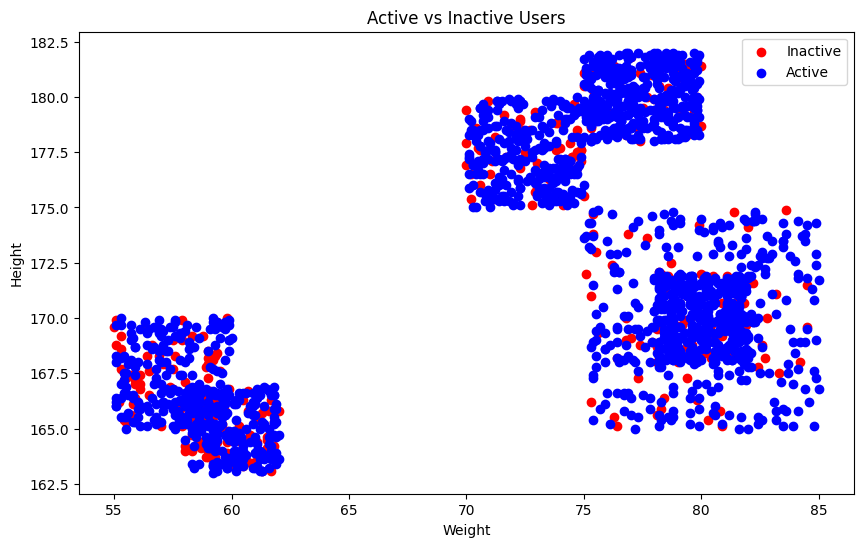

In [26]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df[df['inactive']]['weight'], df[df['inactive']]['height'], color='red', label='Inactive')
plt.scatter(df[~df['inactive']]['weight'], df[~df['inactive']]['height'], color='blue', label='Active')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Active vs Inactive Users')
plt.legend()
plt.show()

### Data preparation for predicting

In [27]:
# Change True to 1 and False to 0 in the inactive column
df['inactive'] = df['inactive'].astype(int)

# Show DataFrame
print(df)

      record_id        user_id  activity_timestamp  weight  height  \
13    rec_00945  Budget Billie 2023-02-21 20:12:12    58.7   164.9   
26    rec_01139  Budget Billie 2023-02-26 20:43:05    58.3   166.1   
27    rec_00934  Budget Billie 2023-02-28 14:38:58    60.9   166.0   
36    rec_01089  Budget Billie 2023-03-04 14:03:35    59.4   166.0   
39    rec_01028  Budget Billie 2023-03-05 12:55:50    59.0   165.1   
...         ...            ...                 ...     ...     ...   
1855  rec_00709     Vegan Vera 2025-02-02 19:49:23    55.3   167.7   
1865  rec_00713     Vegan Vera 2025-02-05 14:58:54    55.9   167.4   
1871  rec_00698     Vegan Vera 2025-02-07 13:59:31    57.6   165.0   
1875  rec_00864     Vegan Vera 2025-02-08 07:51:31    59.3   166.5   
1881  rec_00896     Vegan Vera 2025-02-11 12:08:58    56.3   169.8   

     country_of_residence           dish_name  meal_type  \
13                  India  Ramen with Veggies     Dinner   
26                  India  Ramen with V

### Define feature selection and target variable

In [28]:
features = ['weight', 'height', 'country_of_residence', 'meal_type', 'hunger_rating', 'meal_rating']
X = pd.get_dummies(df[features])
y = df['inactive']

 ### Heatmap with target variable

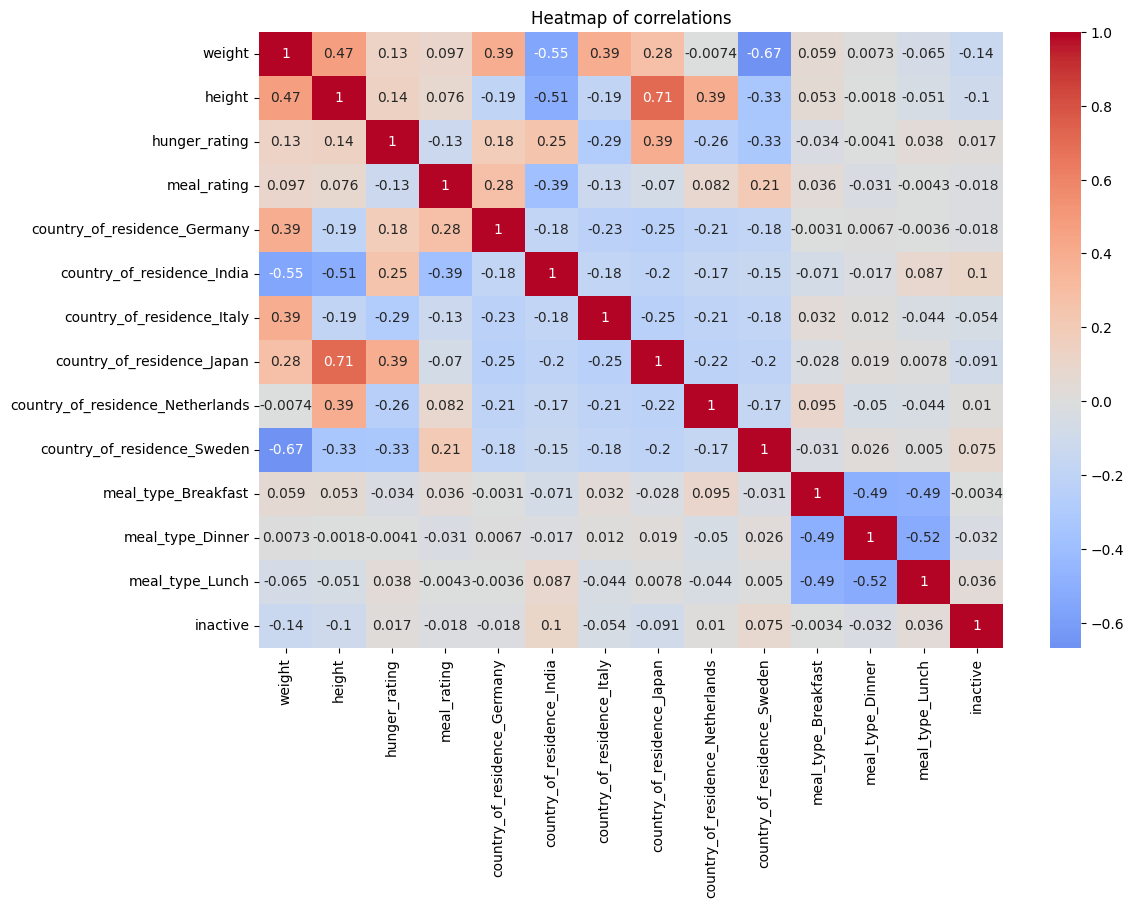

In [29]:
# Heatmap with target variable

import seaborn as sns
import matplotlib.pyplot as plt

# Combine the features and the target in a DataFrame
df_combined = pd.concat([X, y], axis=1)

# Calculate correlations
correlation_matrix = df_combined.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of correlations')
plt.show()


### Heatmap with features (without target)

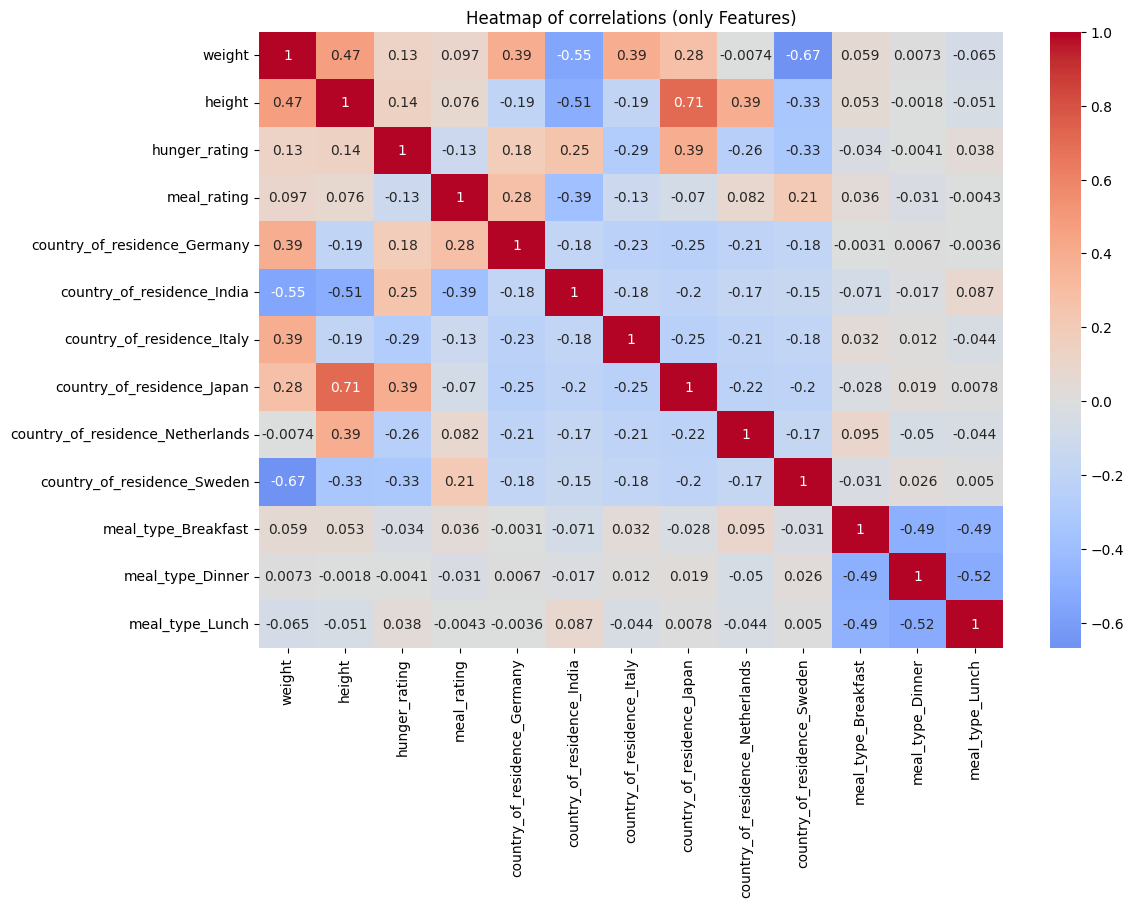

In [30]:
# Heatmap with features (without target variable)

# Calculate correlations
correlation_matrix2 = X.corr()

# Create Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of correlations (only Features)')
plt.show()


## Baseline model with logistic regression

First we use Logistic Regression as a simple and interpreted model for binary classification tasks.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

# Data split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Prediction
y_pred_logreg = logreg.predict(X_test)

# Calculate metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# Show results
print(f'Accuracy of Logistic Regression: {accuracy_logreg}')
print(f'ROC-AUC: {roc_auc_logreg}')
print(f'Precision: {precision_logreg}')
print(f'Recall: {recall_logreg}')
print(f'F1-Score: {f1_logreg}')
print('Confusion Matrix:')
print(conf_matrix_logreg)


Accuracy of Logistic Regression: 0.8298245614035088
ROC-AUC: 0.5
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Confusion Matrix:
[[473   0]
 [ 97   0]]


c:\Users\Vanessa\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As you can see, although the accuracy is quite ok, the model does not work due to the unbalanced data set and distribution. Therefore, in a first approach, we try to adjust the class weights (Even if it is only a baseline model, otherwise we cannot compare it.).

In [32]:
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

# Prediction
y_pred_logreg = logreg.predict(X_test)

# Calculate metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# Show results
print(f'Accuracy of Logistic Regression: {accuracy_logreg}')
print(f'ROC-AUC: {roc_auc_logreg}')
print(f'Precision: {precision_logreg}')
print(f'Recall: {recall_logreg}')
print(f'F1-Score: {f1_logreg}')
print('Confusion Matrix:')
print(conf_matrix_logreg)

Accuracy of Logistic Regression: 0.6350877192982456
ROC-AUC: 0.5875416839214489
Precision: 0.23696682464454977
Recall: 0.5154639175257731
F1-Score: 0.3246753246753247
Confusion Matrix:
[[312 161]
 [ 47  50]]


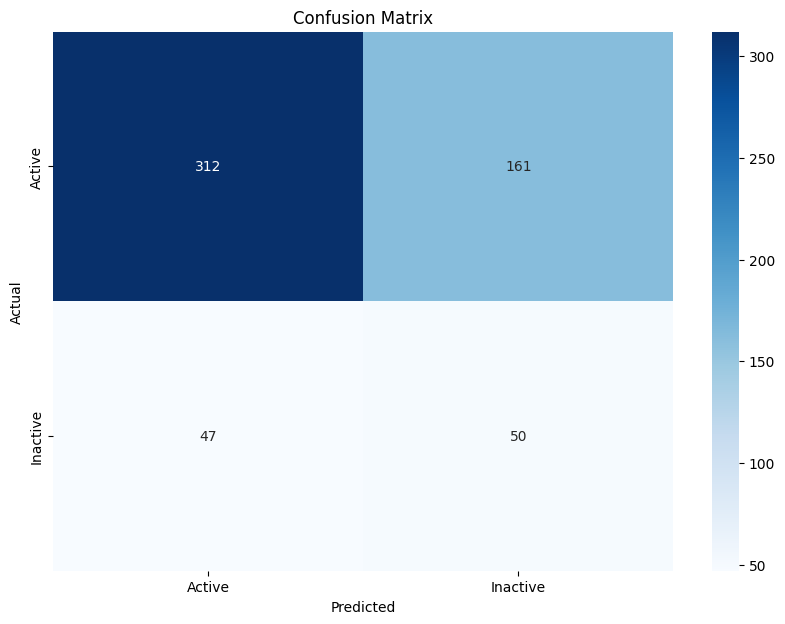

In [33]:
# Visualisiation of Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In churn prediction, it is often important to keep an eye on both precision and recall. High precision means that there are few false positive predictions. High recall means that there are few false negatives. The F1 score can be a good compromise, as it represents a balanced measure.

As you can see, the model is not performing so well. An F1 score of 1, a recall of 1, a precision score of 1 would be ideal, but is not realistic (means, model is overfitting).

The ROC-AUC score helps to understand how well a model can distinguish between the classes. It should be minimum 0,7 or better (0,8-0,9 is good, 0,9 -1 is excellent).

## Random Forest model

We now use the Random Forest Cassifier as a model. *This model is robust and performs well on classification tasks with many features, is good at dealing with non-linear relationships and interactions between features.*

Here, too, we are already focussing directly on balanced class weights.


In [34]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Data split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a model
clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
clf.fit(X_train, y_train)

# Prediction
y_pred_rf = clf.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Show results
print(f'Accuracy of Random Forest: {accuracy_rf}')
print(f'ROC-AUC: {roc_auc_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'F1-Score: {f1_rf}')
print('Confusion Matrix:')
print(conf_matrix_rf)

Accuracy of Random Forest: 0.7964912280701755
ROC-AUC: 0.5045007737407642
Precision: 0.1935483870967742
Recall: 0.061855670103092786
F1-Score: 0.09375
Confusion Matrix:
[[448  25]
 [ 91   6]]


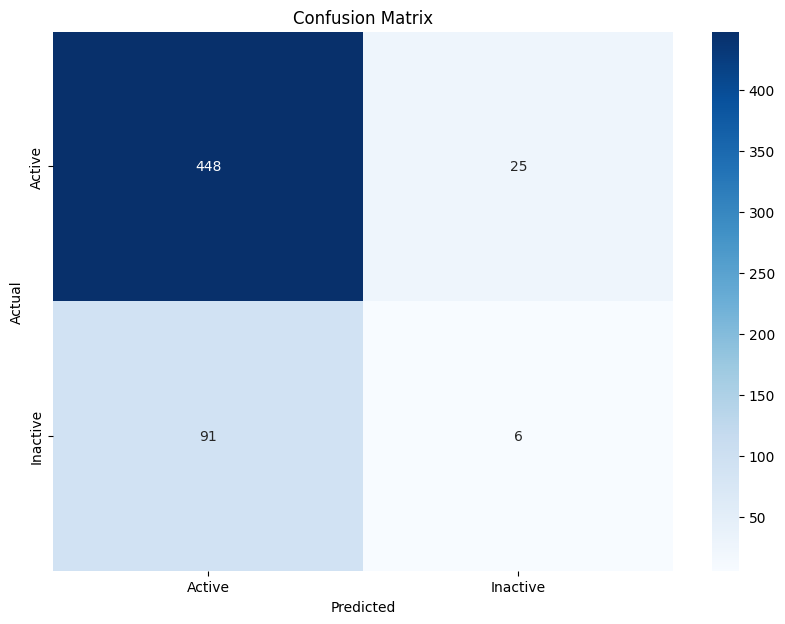

In [35]:
# Visualisiation of Confusion Matrix for Random Forest
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Feature Importance

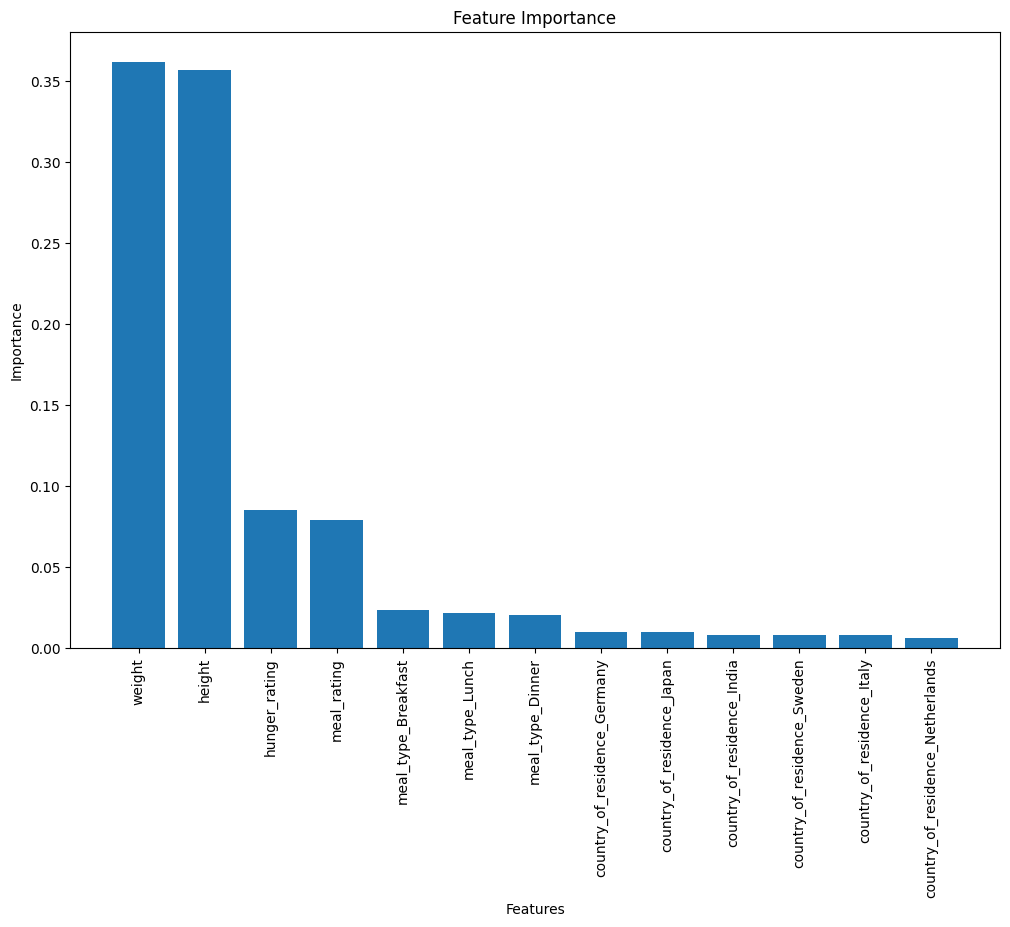

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


The feature importance appears rather random in relation to the data. This may have something to do with the fact that they were generated synthetically. Instead, we want to try another variant here to improve the model: SMOTE.

__SMOTE (Synthetic Minority Over-sampling Technique) can also be applied to the Random Forest. SMOTE is a minority class over-sampling technique that creates synthetic examples to reduce class imbalance.__

In [38]:
from imblearn.over_sampling import SMOTE

# Data split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Create and train a model
clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
clf.fit(X_resampled, y_resampled)

# Prediction
y_pred_rf_smote = clf.predict(X_test)

# Calculate metrics
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
roc_auc_rf_smote = roc_auc_score(y_test, y_pred_rf_smote)
precision_rf_smote = precision_score(y_test, y_pred_rf_smote, zero_division=1)
recall_rf_smote = recall_score(y_test, y_pred_rf_smote)
f1_rf_smote = f1_score(y_test, y_pred_rf_smote)
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)

# Show results
print(f'Accuracy of Random Forest: {accuracy_rf_smote}')
print(f'ROC-AUC: {roc_auc_rf_smote}')
print(f'Precision: {precision_rf_smote}')
print(f'Recall: {recall_rf_smote}')
print(f'F1-Score: {f1_rf_smote}')
print('Confusion Matrix:')
print(conf_matrix_rf_smote)


Accuracy of Random Forest: 0.7228070175438597
ROC-AUC: 0.4969813212440879
Precision: 0.16483516483516483
Recall: 0.15463917525773196
F1-Score: 0.1595744680851064
Confusion Matrix:
[[397  76]
 [ 82  15]]


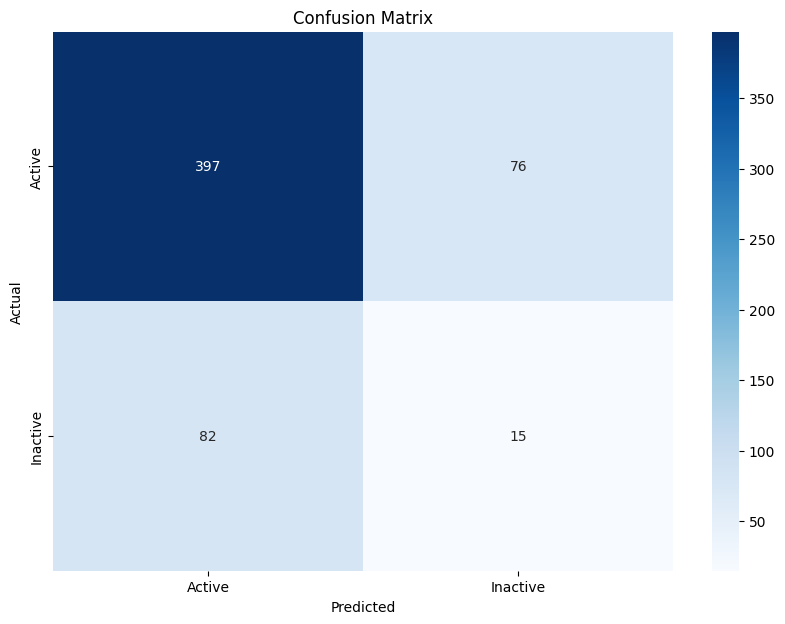

In [39]:
# Visualisiation of Confusion Matrix for Random Forest with SMOTE
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Calculation of metrics for all models

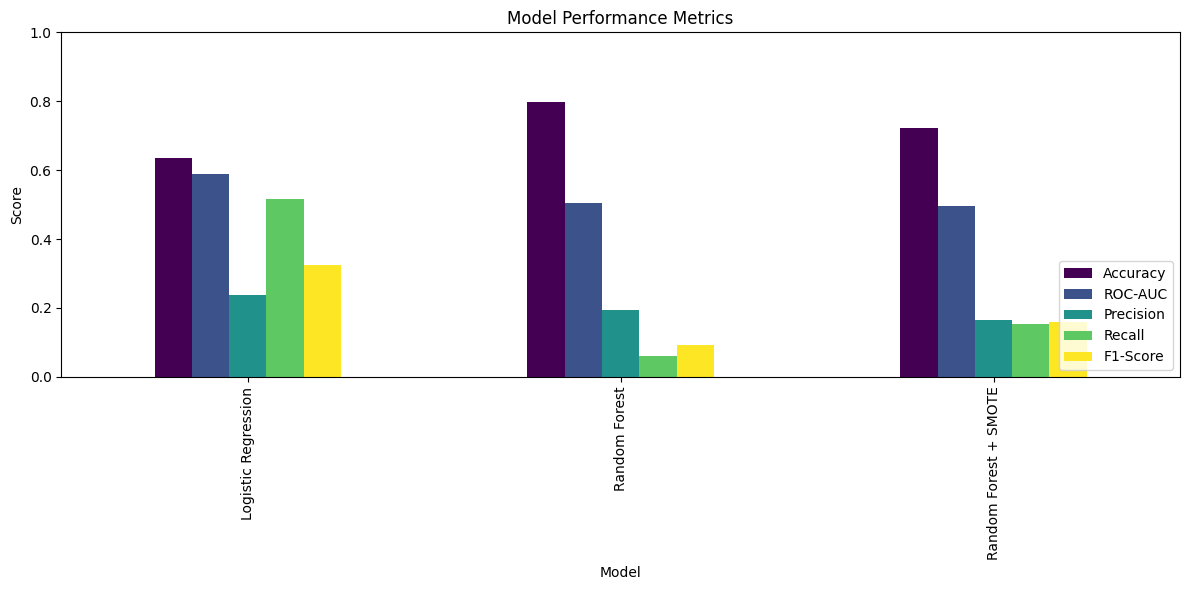

Confusion Matrix for Logistic Regression:
[[312 161]
 [ 47  50]]

Confusion Matrix for Random Forest:
[[448  25]
 [ 91   6]]

Confusion Matrix for Random Forest + SMOTE:
[[397  76]
 [ 82  15]]


In [40]:
# Calculation of metrics for all models
metrics = {
    'Model': ['Logistic Regression', 'Random Forest', 'Random Forest + SMOTE'],
    'Accuracy': [accuracy_score(y_test, y_pred_logreg), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_rf_smote)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred_logreg), roc_auc_score(y_test, y_pred_rf), roc_auc_score(y_test, y_pred_rf_smote)],
    'Precision': [precision_score(y_test, y_pred_logreg, zero_division=1), precision_score(y_test, y_pred_rf, zero_division=1), precision_score(y_test, y_pred_rf_smote, zero_division=1)],
    'Recall': [recall_score(y_test, y_pred_logreg), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_rf_smote)],
    'F1-Score': [f1_score(y_test, y_pred_logreg), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf_smote)]
}

metrics_df = pd.DataFrame(metrics)

# Visualisation of the metrics
fig, ax = plt.subplots(figsize=(12, 6))
metrics_df.set_index('Model').plot(kind='bar', ax=ax, colormap='viridis')
ax.set_title('Model Performance Metrics')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Show confusion matrix for each model
print('Confusion Matrix for Logistic Regression:')
print(confusion_matrix(y_test, y_pred_logreg))
print('\nConfusion Matrix for Random Forest:')
print(confusion_matrix(y_test, y_pred_rf))
print('\nConfusion Matrix for Random Forest + SMOTE:')
print(confusion_matrix(y_test, y_pred_rf_smote))


# CONCLUSION

*Interestingly, the simpler model (logistic Regression) performs better than the more complex model (Random Forest), when we compare the F1 Score and the ROC AUC. There may be various reasons for this:*

__Data quality:__

* If the data contains a lot of noise, a simple model such as logistic regression can generalise better as it is less prone to overfitting.

* Logistic regression can perform well with linear relationships between the features and the target. If the relationships in the data are predominantly linear, logistic regression can perform very well.

__Amount of data:__

* Logistic regression can perform better with smaller datasets as it is less complex and requires less data to achieve good results. Random forest models often require more data to fully utilise their strengths.

__Settings:__

* It may also be that the hyperparameters of the Random Forest model are not set optimally. Hyperparameter tuning can help to improve performance. 

*Improve the hyperparameters of the random forest, would be a possible further step that can be taken. With real data, the approach is promising and can provide valuable insights, e.g. for a marketing department that wants to activate inactive users through email marketing or push messages.*